## Using InfoPy to reproduce Schreiber's paper examples (UNDER CONSTRUCTION)

In [184]:
import numpy             as np 
import matplotlib.pyplot as plt 
import pandas            as pd
import multiprocessing
from   joblib            import Parallel, delayed

In [185]:
M         = 100     # Number of elements in the map
Transient = 100000  # Transient time
T         = 100000  # Simulation time
    
def tentMap(x_in):
    ###############################################################################
    # Description: Equations for the ulam map. Return the next value of the map
    # given the previous one.
    # > Inputs: 
    # x_in: Input or previous value of the map
    # > Outputs:
    # Next value of the map.
    ###############################################################################
    return x_in * 2.0 * (x_in < 0.5) + (2 - 2 * x_in) * (x_in >= 0.5)
    
def simulateMap(M, Transient, T, coupling = 0.05):
    ###############################################################################
    # Description: Simulate tent.
    # > Inputs:
    # f_map: Map function
    # coupling: Counpling between the map elements
    # M: Number of elements in the map
    # Transiente: Transient time
    # T: Simulation time
    # > Output
    # binMapValues: The binary output of each map element
    ###############################################################################
        
    # Initializing map values. For the tent map it's initialized with random uniform values.
    values = np.random.rand(M)  

    # Run transient
    for t in range(1, Transient):
        for i in range(len(values)):
            if i == 0:
                values[i] = tentMap( coupling * values[-1] + (1 - coupling) * values[i])
            else:
                values[i] = tentMap( coupling * values[i-1] + (1 - coupling) * values[i])


    mapValues       = np.zeros([T, M])
    mapValues[0, :] = values

    # Run the map simulation
    for t in range(1, T):
        for m in range(0, M):
            if m == 0:
                mapValues[t, m] = tentMap( coupling * mapValues[t-1, -1] + (1 - coupling) * mapValues[t-1, m] )
            else:
                mapValues[t, m] = tentMap( coupling * mapValues[t-1, m-1] + (1 - coupling) * mapValues[t-1, m] )

    binMapValues = (mapValues >= 0.5).astype(int)
    return binMapValues
    
def simulateMapCouplings(M, Transient, T, couplings = np.arange(0, 0.052, 0.002), n_jobs = 1):
    ###############################################################################
    # Description: This function allows to run simulateMap in parallel.
    # > Inputs:
    # f_map: Map function
    # M: Number of elements in the map
    # Transiente: Transient time
    # T: Simulation time
    # couplings: A numpy array with coupling values
    # n_jobs: Number of jobs to use
    # > Output
    # binMapValues: The binary output of each map element for each coupling
    ###############################################################################
    binMapValues = Parallel(n_jobs=n_jobs, backend='loky', max_nbytes=1e6)(
            delayed(simulateMap)(M, Transient, T, c) for c in couplings
            )
    
    return np.squeeze(binMapValues)

In [3]:
def tentMapTE(couplings = np.arange(0, 0.052, 0.002)):
    ###############################################################################
    # Description: Returns analytical values of TE for the tent map
    # > Inputs:
    # couplings: A numpy array with coupling values
    # n_jobs: Number of jobs to use
    # > Output
    # Transfer entropy as a funtion of the coupling for the tent map
    ###############################################################################
    return (0.77**2)*(couplings**2)/np.log(2)

In [4]:
couplings    = np.arange(0, 0.052, 0.002)
binMapValues = simulateMapCouplings(M, 100, T, couplings, n_jobs = -1)

In [2]:
from infoPy.discrete import BinTransferEntropy

In [3]:
def pairTE(binMapValues, M, i):
    if i == 0:
        return BinTransferEntropy(binMapValues[:,M-1], binMapValues[:,0], lag = 0)
    else:
        return BinTransferEntropy(binMapValues[:,i-1], binMapValues[:,i], lag = 0)

In [4]:
TE = np.zeros([couplings.shape[0], M-1])

for i in range( couplings.shape[0] ):
    TE[i] = Parallel(n_jobs=-1, backend='loky', max_nbytes=1e6)
                    (delayed(pairTE)(binMapValues[i], M, m) for m in range(1, M)
                    )

IndentationError: unexpected indent (<ipython-input-4-b4a513454bdf>, line 5)

In [ ]:
TE_tent = tentMapTE(couplings)

In [ ]:
plt.figure()
plt.plot(couplings, TE_tent, 'k--', lw=2)
plt.errorbar(couplings, TE.mean(axis=1), TE.std(axis=1) / np.sqrt(M), lw=2)
plt.legend(['TE analytical', 'TE estimated'])
plt.title('Transfer Entropy for the Tent Map')
plt.ylabel('TE [bits]')
plt.xlabel('Counpling')

In [2]:
from infoPy.continuous.kernel import *

In [175]:
def KernelDensityEstimator(x, bandwidth, kernel = 'tophat', metric = 'euclidean', algorithm = 'auto'):
	#####################################################################################################
	# Description: Uses kernel estimaton to compute probabiliry distribution
	# > Inputs:
	# x: Data matrix must have size [N_variables, N_observations].
	# bandwidth: Kernel bandwidth
	# kernel: Kernel shape [‘gaussian’|’tophat’|’epanechnikov’|’exponential’|’linear’|’cosine’]
	# metric: Distance metric to use [‘euclidean’|‘manhattan’|‘chebyshev’|‘minkowski’|]
	# for more see: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
	# > Outputs:
	# Probability distribution of the data obtained with kernel density estimation
	#####################################################################################################
	from sklearn.neighbors import KernelDensity

	# Checking data shape
	if x.shape[0] >= 1:
		x = x.T
	if len(x.shape) == 1:
		x = x[np.newaxis, :].T

	d = x.shape[0]

	kde = KernelDensity(bandwidth=bandwidth, kernel=kernel, metric=metric, algorithm=algorithm, leaf_size=3)

	if d == 1:
		kde.fit(x)
		p = kde.score_samples(x)

	else:
		kde.fit(x)
		p = kde.score_samples(x)
	
	return np.exp(p)

In [176]:
c = np.arange(0, 1.02, 0.02) 

In [177]:
def TEulam(i, bw, lag, metric, kernel, algorithm): 
    #data=np.loadtxt('data_schreiber/ulam/ulam_'+str(i)+'.dat', delimiter=',')
    #x = data[:,0]#(data[:,0] - data[:,0].mean())/data[:,0].std()
    #y = data[:,1]#(data[:,1] - data[:,1].mean())/data[:,1].std()
    x, y = simulate_map(c[i])
    return KernelEstimatorTransferEntropy(x, y, bandwidth =bw, 
                                          metric=metric, lag=lag, kernel=kernel, algorithm=algorithm), \
           KernelEstimatorTransferEntropy(y, x, bandwidth = bw, 
                                          metric=metric, lag=lag, kernel=kernel, algorithm=algorithm)

In [181]:
TE = Parallel(n_jobs=-1, backend='loky', max_nbytes=1e6)(delayed(TEulam)
             (i, .2, 0, 'chebyshev', 'gaussian', 'auto')   
             for i in range(0, 51)) 

In [182]:
jidt = np.loadtxt('data_schreiber/ulam/jidt_ulam.txt', delimiter=',')

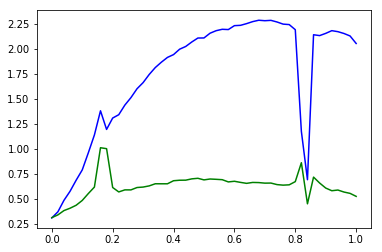

In [183]:
TE = np.squeeze(TE)

plt.plot(c,TE[:,0], 'b')
plt.plot(c,TE[:,1], 'g')
#plt.plot(c,jidt[:,1], 'b--')
#plt.plot(c,jidt[:,2], 'g--')

In [146]:
data=np.loadtxt('data_schreiber/ulam/ulam_'+str(1)+'.dat', delimiter=',') 
x = (data[:,0] - data[:,0].mean())/data[:,0].std()
y = (data[:,1] - data[:,1].mean())/data[:,1].std()

In [17]:
x.std()

0.9999999999999998

In [168]:
def ulamMap(xIn):
    return 2 - xIn**2

def simulate_map(coupling):
    M = 100
    transientLength = 100
    iterates = 5000

    #Initialise first row randomly (values should be in range [-2,2])
    transientMapValues = -2 + np.random.rand(1,M) * 4
    # Run transients - no need to keep the transient values
    for t in range(1, transientLength):
        transientMapValues = ulamMap(coupling * np.hstack( [transientMapValues[0,M-1], transientMapValues[0,0:M-1]] ) + \
                                     (1 - coupling) * transientMapValues)

    #Run iterates - now keep the iterated map values
    mapValues = np.zeros([iterates, M])
    mapValues[0,:] = transientMapValues
    for t in range(1, iterates):
        mapValues[t, :] = ulamMap(coupling * np.hstack( [mapValues[t-1,M-1], mapValues[t-1,0:M-1]] ) \
                                  + (1 - coupling) * mapValues[t-1,:])

    #Take only the first two columns, as Schreiber does
    x1 = mapValues[:,0]
    x2 = mapValues[:,1]
    return x1, x2

In [63]:
x1

array([ 1.59149856, -0.36063599,  1.88536519, ..., -0.14170796,
        1.98827976, -1.77171786])

In [64]:
x2

array([-0.71439733,  1.55340262, -0.29559422, ...,  1.05203056,
        0.94289567,  1.0710831 ])

M

In [44]:
[ transientMapValues[0,M] , transientMapValues[0,0:M-1] ]

IndexError: index 100 is out of bounds for axis 1 with size 100

array([ 1.87446549, -0.733071  , -1.1462699 , -0.16728044,  1.84729626,
       -1.17656279,  0.73337695, -1.55254843, -0.3011345 ,  1.91142799,
        1.94793726,  1.71052595, -1.06794712, -1.97017815, -1.70537487,
       -0.54423783,  0.53114372, -1.12375619, -1.4675484 , -0.81085837,
       -1.35134591, -0.49283988, -1.0367385 ,  1.67303513, -0.67852585,
       -1.64860651, -0.70901163, -0.78379208, -0.39174614, -0.25476119,
       -1.32787068,  0.65534016,  0.26490199, -0.22895275,  1.22955632,
       -0.39363736,  1.08710379,  1.28874302,  1.65810061, -1.46102432,
        0.91183765, -1.72219349, -1.38138445, -0.10381496,  0.93531047,
        1.01536994, -0.14420009,  1.4231925 , -0.9995047 ,  1.26692886,
       -1.93169279,  1.18633021, -1.69930422, -1.8722241 ,  0.71127928,
       -1.45664377, -1.55174576, -0.07559735, -0.17659996,  0.84561492,
       -0.11067859, -0.01713984, -0.89615096,  1.12501751,  1.97544248,
        0.89922447,  1.99426818,  0.59020585,  0.03749976,  0.52

array([-0.733071  , -1.1462699 , -0.16728044,  1.84729626, -1.17656279,
        0.73337695, -1.55254843, -0.3011345 ,  1.91142799,  1.94793726,
        1.71052595, -1.06794712, -1.97017815, -1.70537487, -0.54423783,
        0.53114372, -1.12375619, -1.4675484 , -0.81085837, -1.35134591,
       -0.49283988, -1.0367385 ,  1.67303513, -0.67852585, -1.64860651,
       -0.70901163, -0.78379208, -0.39174614, -0.25476119, -1.32787068,
        0.65534016,  0.26490199, -0.22895275,  1.22955632, -0.39363736,
        1.08710379,  1.28874302,  1.65810061, -1.46102432,  0.91183765,
       -1.72219349, -1.38138445, -0.10381496,  0.93531047,  1.01536994,
       -0.14420009,  1.4231925 , -0.9995047 ,  1.26692886, -1.93169279,
        1.18633021, -1.69930422, -1.8722241 ,  0.71127928, -1.45664377,
       -1.55174576, -0.07559735, -0.17659996,  0.84561492, -0.11067859,
       -0.01713984, -0.89615096,  1.12501751,  1.97544248,  0.89922447,
        1.99426818,  0.59020585,  0.03749976,  0.5240485 , -0.43

In [97]:
import random
import math
covs = np.arange(0, 1, .1)
TE=[]
TEa=[]
for covariance in covs:
    print('Cov = '  + str(covariance))
    # Generate some random normalised data.
    numObservations = 10000
    # Source array of random normals:
    sourceArray = [random.normalvariate(0,1) for r in range(numObservations)]
    # Destination array of random normals with partial correlation to previous value of sourceArray
    destArray = [0] + [sum(pair) for pair in zip([covariance*y for y in sourceArray[0:numObservations-1]], \
                                                 [(1-covariance)*y for y in [random.normalvariate(0,1) for r in range(numObservations-1)]] ) ]
    # Uncorrelated source array:
    sourceArray2 = [random.normalvariate(0,1) for r in range(numObservations)]

    corr_expected = covariance / (1 * math.sqrt(covariance**2 + (1-covariance)**2));
    TEa.append( -0.5*math.log(1-math.pow(corr_expected,2))/math.log(2) )
    TE.append( KernelEstimatorTransferEntropy(sourceArray, destArray, bandwidth = .5, 
                                              metric='euclidean', lag=0, kernel='tophat') )

Cov = 0.0
Cov = 0.1
Cov = 0.2
Cov = 0.30000000000000004
Cov = 0.4
Cov = 0.5
Cov = 0.6000000000000001
Cov = 0.7000000000000001


KeyboardInterrupt: 

Text(0, 0.5, 'TE [bits]')

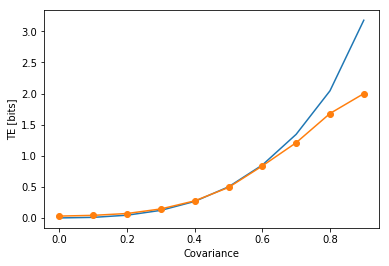

In [83]:
plt.plot(covs, TEa)
plt.plot(covs, TE,'o-')
plt.xlabel('Covariance')
plt.ylabel('TE [bits]')  